# Exercise 4: Interactively Explore Data in Spark

This Notebook will provide you with an overview of techniques that you can use to interactively explore data in an Azure HDInsight Spark cluster.

#### Step 1 - Accessing the Data

You have already seen that Azure HDInsight maps HDFS volumes over the top of Azure Blob storage when it uses a container within the Azure Storage account configured during the cluster provisioning step as the default volume for the cluster.  It is also possible to work with data in other Blob Storage accounts as well.  This is one way that the data you will be working with can remain across multiple provisionings and deletions of your Spark cluster.

For this lab, you will be working with Food Inspection data collected by the City of Chicago from January 1, 2010 to the time of this writing.  A description of the data can be found [here](https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5).  The dataset contains approximately 125,000 rows in 15 columns. 

This data is going to be accessed from a an Azure Storage account maintained specifically for this lab.  To access data in a separate account, you use a URL that indicates the wasb(s) protocol and has the following structure:
> wasbs://**container**@**account-name**.blob.core.windows.net/**file-path**

To access content in a container, either the storage account access key needs to be configured in your cluster settings, or the container needs to be set to allow public access.  Note that allowing public access allows read-only access to the data file.

Run the code in the following cell. The code instructs the current execution context to load the `Food_InspectionsNoHeader.csv` file from the `sparklab` container in the `a4rsparkresources` storage account.  It then defines a function to be used to parse the comma-separated entries in each line in the file and creates a Resilient Distributed Dataset (RDD) instance that can be used to access the date in the file.  You will learn more about RDDs in the next exercise.

*(Note - this very first cell run might take a little extra time, as environment resources are being provisioned.)*

In [1]:
# Obtain a reference to the text file
filename = 'wasbs://sparklab@a4rsparkresources.blob.core.windows.net/FoodInspectionsNoHeader.csv'
inspectionsFile = sc.textFile(filename)

# Process each line of the CSV file by mapping them through a parse function.
def csvParse(s):
    import csv
    from StringIO import StringIO
    sio = StringIO(s)
    value = csv.reader(sio).next()
    sio.close()
    return value
inspectionDataset = inspectionsFile.map(csvParse)

#### Step 2 - Examine the raw data
The previous step mentioned that your data would be imported as a Resilient Distributed Dataset (RDD).  An RDD represents an immutable and distributed collection of elements that can be operated on by a Spark cluster in  parallel.  The RDD is a fundamental abstraction that a Spark cluster uses to do its work and which allows Spark clusters to obtain the scale and speeds they are known for.

Run the code in the following two cells.  The instruction in the first cell displays the content of the first row of data.  The second cell counts the total number of records in the cell.

In [2]:
# Examine the first record in the dataset
inspectionDataset.first() #take(1)

['1931400',
 '7-ELEVEN # 37622A',
 '7 ELEVEN',
 '2442936',
 'Grocery Store',
 'Risk 3 (Low)',
 '4 W JACKSON BLVD ',
 '',
 'IL',
 '',
 '05/23/2016',
 'License Re-Inspection',
 'Pass',
 '41.87828615621557',
 '-87.62780446623054']

In [3]:
# Display the total number of records in the entire dataset
inspectionDataset.count()

125279

#### Step 3 - Load the data into a DataFrame

Although the Resilient Distributed Database can be used directly to examine data, the APIs provided for working with RDDs are generally fairly coarse and there is no notion of *"schema"* for the data being presented.  There are two techniques that can be used to access this data at a higher level.  The first is via DataFrames.

DataFrames provide structured access to your data that allow you to treat the data much as a database table would - there are named columns over the top of the vast number of  rows of data.  There are actually several APIs available for working with DataFrames ([Pandas](http://pandas.pydata.org/) and [Spark DataFrames](https://spark.apache.org/docs/1.5.1/sql-programming-guide.html#dataframes) among them), but the general workflow is similar in most cases.

To work with a DataFrame, you either provide schema information that describes the data in the RDD, or in some cases, you can import metadata directly, depending on the type of file(s) that supply the data.  You then create the DataFrame from the schema and the data.

Run the code in the following two cells. The instructions in the first cell specify a schema for the Food Inspection data, based on a review of the data from the data provider and an analysis of the content in the RDD.  Then the DataFrame is created from this schema and the data loaded in the previous step.

In the second cell, you will actually start to examine the data at your disposal.  In this case, you will use the DataFrame commands to list all of the distinct values available in the *results* column.

In [4]:
from pyspark.sql.types import *

# Configure the schema that describes the data being imported 
schema=StructType([
        StructField('Inspection ID', StringType(), False),
        StructField('DBA Name', StringType(), False),
        StructField('AKA Name', StringType(), True),
        StructField('License#', StringType(), False),
        StructField('FacilityType', StringType(), True),
        StructField('Risk', StringType(), True),
        StructField('Address', StringType(), True),
        StructField('City', StringType(), True),
        StructField('State', StringType(), True),
        StructField('Zip', StringType(), True),
        StructField('InspectionDate', StringType(), False),
        StructField('InspectionType', StringType(), False),
        StructField('Results', StringType(), False),
        StructField('Latitude', StringType(), True),
        StructField('Longitude', StringType(), True)])

# Create a dataframe that brings the data and the schema together
inspectionDataframe = sqlContext.createDataFrame(inspectionDataset, schema)

#  You could uncomment the line below to emit the schema for your DataFrame, which should match the one you defined.
# inspectionDataframe.printSchema()

In [5]:
inspectionDataframe.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|           Not Ready|
|                Fail|
|            No Entry|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+



#### Step 4 - Using SQL to Examine Your Data

One of the interesting things you can do with DataFrames is to register them as temporary Apache Hive tables which are available to your current SQLContext.  
In addition, results from SQL commands are automatically displayed in Jupyter notebooks in interactive frames.  Not only can you see data as a table, but you can also display it visually in chart form.

Run the code in the following several cells. The first cell will register the *inspections* temporary table which can then be used to access your data.  The next instruction uses a programmatic approach to access this SQL table and obtain the count of each of the result values.

The gist of these queries is to explore the counts of different Inspection Type values overall and in the case of a failed food inspection, as well as to do the same for Facility Type.  This kind of analysis would be perhaps done to gain insight into factors that might contribute to a *"Fail"*  outcome.

These queries also all include the `%%time` Magic Instruction.  This will display the execution time of these queries after the results.  Recall that these queries are executing against an unindexed set of approximately 125,000 records, and the times that are displayed should be relatively short, which highlights the capabilities of your Spark cluster for Big Data analysis.

In [6]:
# Register the dataframe as a temporary table
inspectionDataframe.registerTempTable('inspections')

In [7]:
sqlContext.sql("SELECT results, COUNT(*) as totals FROM inspections GROUP BY results ORDER BY totals DESC").show()

+--------------------+------+
|             results|totals|
+--------------------+------+
|                Pass| 74258|
|                Fail| 24368|
|     Out of Business| 11934|
|  Pass w/ Conditions| 11468|
|            No Entry|  2810|
|           Not Ready|   387|
|Business Not Located|    54|
+--------------------+------+



In [29]:
import pandas


In [27]:
%%time
overallByType = sqlContext.sql("SELECT InspectionType, COUNT(*) AS counts FROM inspections GROUP BY\
    InspectionType ORDER BY counts DESC, InspectionType")
overallByType.show()
overallByType = overallByType.toPandas()

+--------------------+------+
|      InspectionType|counts|
+--------------------+------+
|             Canvass| 65689|
|             License| 16493|
|Canvass Re-Inspec...| 11552|
|           Complaint| 11546|
|License Re-Inspec...|  6323|
|Short Form Complaint|  5003|
|Complaint Re-Insp...|  4716|
|        Consultation|   635|
|Suspected Food Po...|   627|
|  License-Task Force|   605|
|         Tag Removal|   601|
|     Out of Business|   284|
|Task Force Liquor...|   254|
|      Complaint-Fire|   161|
|   Recent Inspection|   144|
|Suspected Food Po...|   144|
|Short Form Fire-C...|   113|
|            No Entry|    60|
|Special Events (F...|    57|
|Complaint-Fire Re...|    44|
+--------------------+------+
only showing top 20 rows

CPU times: user 52 ms, sys: 20 ms, total: 72 ms
Wall time: 5.27 s


In [30]:
%%time
topFailuresByType = sqlContext.sql("SELECT InspectionType, COUNT(*) AS counts FROM inspections WHERE results = 'Fail' \
    GROUP BY InspectionType ORDER BY counts DESC, InspectionType")
topFailuresByType.show()
topFailuresByType = topFailuresByType.toPandas()

+--------------------+------+
|      InspectionType|counts|
+--------------------+------+
|             Canvass| 10403|
|             License|  6522|
|           Complaint|  3749|
|License Re-Inspec...|   856|
|Short Form Complaint|   651|
|Canvass Re-Inspec...|   650|
|Complaint Re-Insp...|   392|
|  License-Task Force|   367|
|Suspected Food Po...|   146|
|Task Force Liquor...|   133|
|     Out of Business|   112|
|        Consultation|   106|
|      Complaint-Fire|    59|
|Short Form Fire-C...|    32|
|            No Entry|    29|
|         Tag Removal|    26|
| Package Liquor 1474|    16|
|Pre-License Consu...|    12|
|   Recent Inspection|    11|
|Special Events (F...|    10|
+--------------------+------+
only showing top 20 rows

CPU times: user 28 ms, sys: 48 ms, total: 76 ms
Wall time: 5.17 s


In [31]:
%%time
overallByFacility = sqlContext.sql("SELECT FacilityType, COUNT(*) AS counts FROM inspections GROUP BY \
               FacilityType ORDER BY counts DESC, FacilityType")
overallByFacility.show()
overallByFacility = overallByFacility.toPandas()

+--------------------+------+
|        FacilityType|counts|
+--------------------+------+
|          Restaurant| 81134|
|       Grocery Store| 17318|
|              School|  7928|
|                    |  4418|
|Daycare (2 - 6 Ye...|  2170|
|              Bakery|  1767|
|Daycare Above and...|  1291|
|Children's Servic...|   888|
|  Daycare Combo 1586|   843|
|Mobile Food Dispe...|   693|
|            Catering|   689|
|      Long Term Care|   675|
|              Liquor|   613|
|           Wholesale|   503|
|        Golden Diner|   349|
|            Hospital|   303|
|Mobile Food Preparer|   212|
|Daycare (Under 2 ...|   176|
|              TAVERN|   172|
|Shared Kitchen Us...|   170|
+--------------------+------+
only showing top 20 rows

CPU times: user 56 ms, sys: 24 ms, total: 80 ms
Wall time: 5.08 s


In [33]:
%%time

topFailuresByFacility = sqlContext.sql("SELECT FacilityType, COUNT(*) AS counts FROM inspections WHERE results = 'Fail' GROUP BY \
FacilityType ORDER BY counts DESC, FacilityType")
topFailuresByFacility.show()
topFailuresByFacility = topFailuresByFacility.toPandas()

+--------------------+------+
|        FacilityType|counts|
+--------------------+------+
|          Restaurant| 15199|
|       Grocery Store|  4229|
|              School|  1380|
|Daycare (2 - 6 Ye...|   440|
|              Bakery|   370|
|                    |   365|
|Daycare Above and...|   236|
|              Liquor|   232|
|Mobile Food Dispe...|   214|
|  Daycare Combo 1586|   198|
|           Wholesale|   175|
|Children's Servic...|   172|
|            Catering|   129|
|      Long Term Care|   125|
|Mobile Food Preparer|    72|
|              TAVERN|    63|
|        Golden Diner|    57|
|            Hospital|    43|
|Daycare (Under 2 ...|    35|
|         GAS STATION|    30|
+--------------------+------+
only showing top 20 rows

CPU times: user 52 ms, sys: 28 ms, total: 80 ms
Wall time: 4.92 s


#### Step 5 - Use Graphical Visualization

It is one thing to look over the tabular data results, and another thing to see the data displayed graphically.  Using rich graphics can help substantially in both understanding and presenting the data being examined.  In this step, you will use the *matplotlib* library that is available to your Spark cluster to visualize the relationship between the data queries that you just ran.

Run the code in the following two cells. In each cell, you are graphing the *overall* and *failure* query results for Inspection Type and Facility Type.  You will be using *matplotlib* to display pie charts for the 3 most frequent items occurring in each category.  The idea here is to try to understand the influence these items have on the occurrence of Food Inspection failures.

['InspectionType', 'counts']


(-1.0112285791667126,
 1.0000000009748535,
 -1.0102168313037443,
 1.0121209002382106)

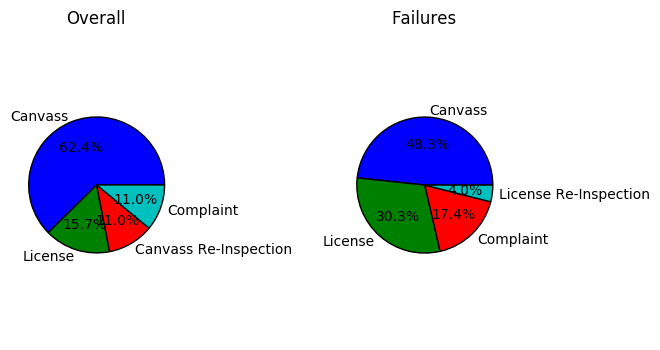

In [35]:
#%%local
%matplotlib inline
import matplotlib.pyplot as plt;

# Plot the Overall Inspection Type values
plt.subplot(1,3,1)
plt.title("Overall")
topOverall = overallByType.head(4)
labels = topOverall['InspectionType']
sizes = topOverall['counts']
print list(topOverall.columns.values)
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

# Plot the Inspection Type Failure values
plt.subplot(1,3,3)
plt.title("Failures")
topFailures = topFailuresByType.head(4)
labels = topFailures['InspectionType']
sizes = topFailures['counts']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

(-1.0166713850923932,
 1.0000000020304887,
 -1.0217739847044489,
 1.0149961819768027)

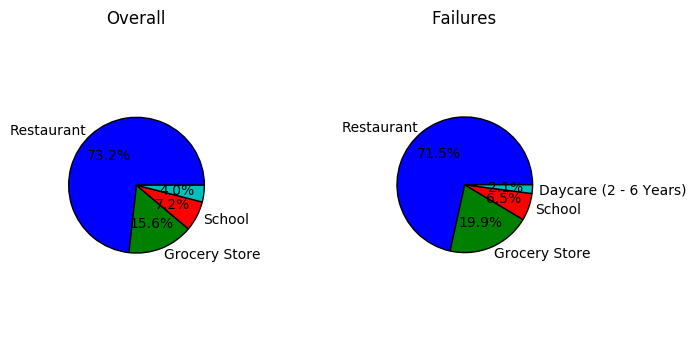

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt;

# Plot the Overall Facility Type values
plt.subplot(1,3,1)
plt.title("Overall")
topOverall = overallByFacility.head(4)
labels = topOverall['FacilityType']
sizes = topOverall['counts']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

# Plot the Facility Type Failure values
plt.subplot(1,3,3)
plt.title("Failures")
topFailures = topFailuresByFacility.head(4)
labels = topFailures['FacilityType']
sizes = topFailures['counts']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')

Looking at the results above (assuming you've run the cells), you may notice that License Inspection Types seem to generate a disproportionate amount of failures (31,5% of failures vs 17.6% of inspections), and Grocery Stores seem to have a marginally high amount of inspection failures (20.3% failures vs 16.3% of the overall inspections).  

These types of insight might lead to actionable information.  It may indicate that the inspection criteria is not being adequately communicated ahead of time to companies that are seeking new licenses and it may be necessary to provide  additional information to these types of businesses.  Additionally, there may be an indication that problems are starting to emerge at grocery stores an an outreach effort to stress the importance of proper hygiene to the store managers may benefit the public overall.

This is obviously just scratching the surface of the ways this data might be analyzed.  It may be interesting to examine these same trends over time rather than en-masse.  Furthermore, the true relationship between the factors may not be obvious at the moment.  In the next Exercise, you will see how to allow the software to help you identify  these relationships via Machine Learning.